In [1]:
from venture import shortcuts

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import codecs
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
ripl = shortcuts.make_lite_ripl()

Couldn't import dot_parser, loading of dot files will not be possible.


# Create Training Data

In [4]:
n = 30

In [5]:
labels = []
data = []
for i in range(1000):
    if np.random.uniform(0,1)>0.5:
        data.append(np.random.normal(0,1))
        labels.append(1)
    else:
        data.append(np.random.normal(10,2))
        labels.append(0)  
all_data = np.array(data)
all_labels = np.array(labels)

In [6]:
training_data = all_data[0:n]
training_labels = all_labels[0:n]

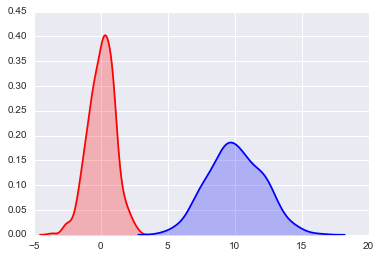

In [7]:
ax = sns.kdeplot(all_data[all_labels==1], shade=True, color="r")
ax = sns.kdeplot(all_data[all_labels==0], shade=True, color="b")

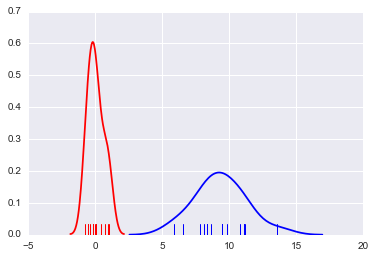

In [8]:
ax = sns.distplot(training_data[training_labels==1], rug=True, hist=False, color="r")
ax = sns.distplot(training_data[training_labels==0], rug=True, hist=False, color="b")

# The Venture Program

In [9]:
program = """

// FIXME - why does this throw error when I write exp( - x ) instead
assume sigmoid = proc(x){1./(1. + exp(0 - x ))};


// Hyper-parameters

assume tolerance_constant = 00000.1;

assume noise_sigma = tag("hyper", 0, gamma(5,1));

assume scale_factor = tag("hyper", 1, gamma(5,1));
assume length_scale = tag("hyper", 2, gamma(5,1));


assume noise_kernel = gp_cov_scale(noise_sigma,gp_cov_delta(tolerance_constant));
assume se_kernel = gp_cov_scale(scale_factor, gp_cov_se(length_scale));

assume covariance_kernel = gp_cov_sum(se_kernel, noise_kernel);

assume zero_mean_function =gp_mean_const(0.);

assume gp = make_gp(zero_mean_function, covariance_kernel);

assume obs_func = proc(x){bernoulli(sigmoid(lookup(gp(array(x)),0)))};

"""
ripl.execute_program(program);

# Create Test Data

In [10]:
n_test = 200
test_data = all_data[n:(n+n_test)]
test_labels = all_labels[n:(n+n_test)]

In [11]:
test_data.shape

(200,)

# Sample from the Prior

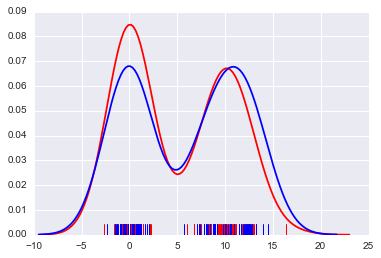

In [12]:
prior_labels = []
prior_length_scale = []
prior_scale_factor = []
prior_noise_sigma = []
for x in test_data:
    ripl.infer("reset_to_prior")
    prior_labels.append(ripl.sample("obs_func(%d)"  % (x,)))
    prior_noise_sigma.append(ripl.sample("noise_sigma")) 
    prior_length_scale.append(ripl.sample("length_scale"))
    prior_scale_factor.append(ripl.sample("scale_factor"))

prior_labels = np.array(prior_labels)
ax = sns.distplot(test_data[prior_labels==1], rug=True, hist=False, color="r")
ax = sns.distplot(test_data[prior_labels==0], rug=True, hist=False, color="b")

# Make Observations

In [13]:
for i,x in enumerate(training_data):
    ripl.observe("obs_func(%d)"  % (x,), training_labels[i])

# Inference

MH inference does not work

In [14]:
ripl.infer("""mh(default, one, 10000)""")

[8.0275]

## What we need to get to run 

In [ ]:
#ripl.infer("grad_ascent(default, all, 0.05, 100, 1)")

## What we probably need to get to work for reasonable inference 

In [ ]:
#ripl.infer("hmc(default, all, 0.05, 100, 1))
# slice sampling?

# Samples from Posterior

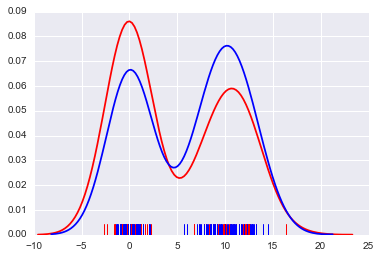

In [15]:
posterior_labels = []
posterior_length_scale = []
posterior_scale_factor = []
posterior_noise_sigma = []
for x in test_data:
    posterior_labels.append(ripl.sample("obs_func(%d)"  % (x,)))
    ripl.infer("""mh("hyper", 0, 1)""")
    posterior_noise_sigma.append(ripl.sample("noise_sigma"))
    ripl.infer("""mh("hyper", 1, 1)""")
    posterior_length_scale.append(ripl.sample("length_scale"))
    ripl.infer("""mh("hyper", 2, 1)""")
    posterior_scale_factor.append(ripl.sample("scale_factor"))
posterior_labels = np.array(posterior_labels)
plt.clf()
ax = sns.distplot(test_data[posterior_labels==1], rug=True, hist=False, color="r")
ax = sns.distplot(test_data[posterior_labels==0], rug=True, hist=False, color="b")

Bad. It should look like this:

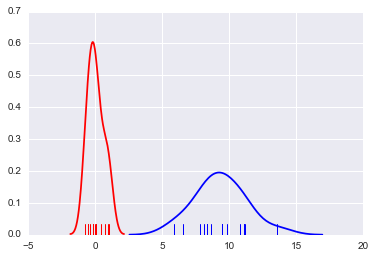

In [16]:
ax = sns.distplot(training_data[training_labels==1], rug=True, hist=False, color="r")
ax = sns.distplot(training_data[training_labels==0], rug=True, hist=False, color="b")

# Shift of Hyperprior to Hyperposterior

### Hyperprior

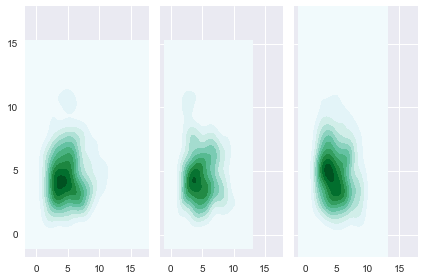

In [17]:
f, axes = plt.subplots(1, 3, sharex=True, sharey=True)
sns.kdeplot(np.array(prior_length_scale), np.array(prior_scale_factor), shade=True, ax=axes[0])
sns.kdeplot(np.array(prior_noise_sigma), np.array(prior_scale_factor), shade=True, ax=axes[1])
sns.kdeplot(np.array(prior_noise_sigma), np.array(prior_length_scale), shade=True, ax=axes[2])
f.tight_layout()

### Hyperposterior

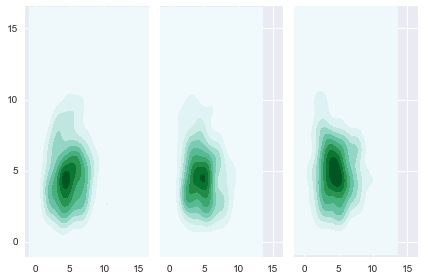

In [18]:
f, axes = plt.subplots(1, 3, sharex=True, sharey=True)
sns.kdeplot(np.array(posterior_length_scale), np.array(posterior_scale_factor), shade=True, ax=axes[0])
sns.kdeplot(np.array(posterior_noise_sigma), np.array(posterior_scale_factor), shade=True, ax=axes[1])
sns.kdeplot(np.array(posterior_noise_sigma), np.array(posterior_length_scale), shade=True, ax=axes[2])
f.tight_layout()